## Stock Prediction using Linear Regression, XGBoost & LSTM

In this notebook, we will only consider the effect of previous many days of close prices as a input. As the best feature is the previous day prices, we will lag the data and try to tune the lookback days for improving the predictions. 

We will implement 4 machine learning models 
1. Linear regression
2. Random Forest
3. XGBoost
4. LSTM


### Object Oriented Pipeline

We have created an Object Oriented based pipeline to Train Multiple stocks with multiple Estimators. Step by Step sequence output of this pipeline is also there in other notebooks. If someone wants to just learn what the pipeline is doing at each step. 

We have created a similar pipeline to Get stocks data and create Extensive feature extraction (around 60 features), it will fetch data for a given stock and get historical data and prepare features using various Technical Indicators and lagging effect. 

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from pylab import rcParams
import numpy as np
import seaborn as sns
import os

from typing import TypeVar, Callable, Sequence
from functools import reduce
T = TypeVar('T')

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.feature_selection import RFECV, SelectFromModel, SelectKBest
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import metrics

from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, GRU
from keras.optimizers import Adam, SGD
%matplotlib inline

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

os.chdir(r'N:\STOCK ADVISOR BOT')


In [2]:
class Stock_Prediction_Modeling():
    def __init__(self, Stocks, models):
        self.Stocks = Stocks
        self.train_Models = models
        self.metrics = {}
        
        
    def get_stock_data(self, Ticker):
        
        file = self.Ticker + '.csv'
        Stock = pd.read_csv(file,  index_col=0)
        print('Loading Historical Price data for ' + self.Ticker + '....')
        #best features
        features_selected = ['Open','High', 'Low','Close(t)', 'QQQ_Close', 'SnP_Close', 'DJIA_Close', 'ATR', 'RSI', 'MA50', 'EMA200', 'Upper_Band']

        self.df_Stock = Stock[features_selected]
        self.df_Stock = self.df_Stock.rename(columns={'Close(t)':'Close'})
        
        self.df_Stock = self.df_Stock.copy()
        self.df_Stock['Diff'] = self.df_Stock['Close'] - self.df_Stock['Open']
        self.df_Stock['High-low'] = self.df_Stock['High'] - self.df_Stock['Low']

        features_selected = ['Close', 'Diff', 'High-low', 'QQQ_Close', 'SnP_Close','DJIA_Close', 'ATR', 'RSI', 'MA50', 'EMA200', 'Upper_Band']
        self.df_Stock = self.df_Stock[features_selected]
        self.df_Stock = self.df_Stock[1000:-70]
        
        print(self.df_Stock.columns)


    def prepare_lagged_features(self, lag_stock, lag_index, lag_diff):

        print('Preparing Lagged Features for Stock, Index Funds.....')
        lags = range(1, lag_stock+1)
        lag_cols= ['Close']
        self.df_Stock=self.df_Stock.assign(**{
            '{}(t-{})'.format(col, l): self.df_Stock[col].shift(l)
            for l in lags
            for col in lag_cols
        })

       
        lags = range(1, lag_index+1)
        lag_cols= ['QQQ_Close','SnP_Close','DJIA_Close']
        self.df_Stock= self.df_Stock.assign(**{
            '{}(t-{})'.format(col, l): self.df_Stock[col].shift(l)
            for l in lags
            for col in lag_cols
        })

        self.df_Stock = self.df_Stock.drop(columns=lag_cols)


        lags = range(1, lag_diff+1)
        lag_cols= ['Diff','High-low']
        self.df_Stock= self.df_Stock.assign(**{
            '{}(t-{})'.format(col, l): self.df_Stock[col].shift(l)
            for l in lags
            for col in lag_cols
        })

        self.df_Stock = self.df_Stock.drop(columns=lag_cols)

        remove_lags_na = max(lag_stock, lag_index, lag_diff) + 1
        print('Removing NAN rows - ', str(remove_lags_na))
        self.df_Stock = self.df_Stock.iloc[remove_lags_na:,]
        return self.df_Stock

    def get_lagged_features(self, Ticker):
        
        self.df_Stock_lagged = self.prepare_lagged_features(lag_stock = 25, lag_index = 10, lag_diff = 5)

        print(self.df_Stock_lagged.columns)
        
        self.df_Stock = self.df_Stock_lagged
        print(self.df_Stock.shape)
        print('Extracted Feature Columns after lagged effect - ')
        print(self.df_Stock.columns)
        
        '''
        self.df_Stock['Close'].plot(figsize=(10, 7))
        plt.title("Stock Price", fontsize=17)
        plt.ylabel('Price', fontsize=14)
        plt.xlabel('Time', fontsize=14)
        plt.grid(which="major", color='k', linestyle='-.', linewidth=0.5)
        plt.show()
        print(self.df_Stock)
        '''




    def create_train_test_set(self):

        #self.df_Stock = self.df_Stock[:-60]
        self.features = self.df_Stock.drop(columns=['Close'], axis=1)
        self.target = self.df_Stock['Close']


        data_len = self.df_Stock.shape[0]
        print('Historical Stock Data length is - ', str(data_len))

        #create a chronological split for train and testing
        train_split = int(data_len * 0.88)
        print('Training Set length - ', str(train_split))

        val_split = train_split + int(data_len * 0.1)
        print('Validation Set length - ', str(int(data_len * 0.1)))

        print('Test Set length - ', str(int(data_len * 0.02)))

        # Splitting features and target into train, validation and test samples 
        X_train, X_val, X_test = self.features[:train_split], self.features[train_split:val_split], self.features[val_split:]
        Y_train, Y_val, Y_test = self.target[:train_split], self.target[train_split:val_split], self.target[val_split:]

        #print shape of samples
        print(X_train.shape, X_val.shape, X_test.shape)
        print(Y_train.shape, Y_val.shape, Y_test.shape)

        return X_train, X_val, X_test, Y_train, Y_val, Y_test

    def get_train_test(self):
        print('Splitting the data into Train and Test ...')
        print(' ')
        if self.ML_Model == 'LSTM':
            self.scale_LSTM_features()
            self.X_train, self.X_test, self.Y_train, self.Y_test = self.create_train_test_LSTM()
        else:
            self.X_train, self.X_val, self.X_test, self.Y_train, self.Y_val, self.Y_test = self.create_train_test_set()

    def get_mape(self, y_true, y_pred): 
        """
        Compute mean absolute percentage error (MAPE)
        """
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    
    def calc_metrics(self):
        print('Evaluating Metrics - MAE, MAPE, RMSE, R Square')
        print(' ')
        if self.ML_Model == 'LSTM':
        
            self.Train_RSq = round(metrics.r2_score(self.Y_train,self.Y_train_pred),2)
            self.Train_EV = round(metrics.explained_variance_score(self.Y_train,self.Y_train_pred),2)
            self.Train_MAPE = round(self.get_mape(self.Y_train,self.Y_train_pred), 2)
            self.Train_MSE = round(metrics.mean_squared_error(self.Y_train,self.Y_train_pred), 2) 
            self.Train_RMSE = round(np.sqrt(metrics.mean_squared_error(self.Y_train,self.Y_train_pred)),2)
            self.Train_MAE = round(metrics.mean_absolute_error(self.Y_train,self.Y_train_pred),2)

            
            self.Test_RSq = round(metrics.r2_score(self.Y_test,self.Y_test_pred),2)
            self.Test_EV = round(metrics.explained_variance_score(self.Y_test,self.Y_test_pred),2)
            self.Test_MAPE = round(self.get_mape(self.Y_test,self.Y_test_pred), 2)
            self.Test_MSE = round(metrics.mean_squared_error(self.Y_test,self.Y_test_pred), 2) 
            self.Test_RMSE = round(np.sqrt(metrics.mean_squared_error(self.Y_test,self.Y_test_pred)),2)
            self.Test_MAE = round(metrics.mean_absolute_error(self.Y_test,self.Y_test_pred),2)
        else:
            
            self.Train_RSq = round(metrics.r2_score(self.Y_train,self.Y_train_pred),2)
            self.Train_EV = round(metrics.explained_variance_score(self.Y_train,self.Y_train_pred),2)
            self.Train_MAPE = round(self.get_mape(self.Y_train,self.Y_train_pred), 2)
            self.Train_MSE = round(metrics.mean_squared_error(self.Y_train,self.Y_train_pred), 2) 
            self.Train_RMSE = round(np.sqrt(metrics.mean_squared_error(self.Y_train,self.Y_train_pred)),2)
            self.Train_MAE = round(metrics.mean_absolute_error(self.Y_train,self.Y_train_pred),2)

            self.Val_RSq = round(metrics.r2_score(self.Y_val,self.Y_val_pred),2)
            self.Val_EV = round(metrics.explained_variance_score(self.Y_val,self.Y_val_pred),2)
            self.Val_MAPE = round(self.get_mape(self.Y_val,self.Y_val_pred), 2)
            self.Val_MSE = round(metrics.mean_squared_error(self.Y_train,self.Y_train_pred), 2) 
            self.Val_RMSE = round(np.sqrt(metrics.mean_squared_error(self.Y_val,self.Y_val_pred)),2)
            self.Val_MAE = round(metrics.mean_absolute_error(self.Y_val,self.Y_val_pred),2)

            self.Test_RSq = round(metrics.r2_score(self.Y_test,self.Y_test_pred),2)
            self.Test_EV = round(metrics.explained_variance_score(self.Y_test,self.Y_test_pred),2)
            self.Test_MAPE = round(self.get_mape(self.Y_test,self.Y_test_pred), 2)
            self.Test_MSE = round(metrics.mean_squared_error(self.Y_test,self.Y_test_pred), 2) 
            self.Test_RMSE = round(np.sqrt(metrics.mean_squared_error(self.Y_test,self.Y_test_pred)),2)
            self.Test_MAE = round(metrics.mean_absolute_error(self.Y_test,self.Y_test_pred),2)


    def update_metrics_tracker(self):
        print('Updating the metrics tracker....')
        if self.ML_Model == 'LSTM':
            #self.metrics[self.Ticker] = {}
            self.metrics[self.Ticker][self.ML_Model] = {'Train_MAE': self.Train_MAE, 'Train_RSq': self.Train_RSq, 'Train_MAPE': self.Train_MAPE , 'Train_RMSE': self.Train_RMSE,
                          'Test_MAE': self.Test_MAE, 'Test_RSq': self.Test_RSq, 'Test_MAPE': self.Test_MAPE, 'Test_RMSE': self.Test_RMSE}
        else:
            ##self.metrics[self.Ticker] = {{}}
            self.metrics[self.Ticker][self.ML_Model] = {'Train_MAE': self.Train_MAE, 'Train_RSq': self.Train_RSq, 'Train_MAPE': self.Train_MAPE , 'Train_RMSE': self.Train_RMSE,
                          'Test_MAE': self.Val_MAE, 'Test_RSq': self.Val_RSq, 'Test_MAPE': self.Val_MAPE, 'Test_RMSE': self.Val_RMSE}

       

    def train_model(self, Ticker):

        for model in self.train_Models:
            self.ML_Model = model
            if self.ML_Model == 'Linear Regression':
                
                print(' ')
                print('Training Linear Regressiom Model')
                
                self.get_train_test()
                
                plt.plot(self.Y_train)
                plt.plot(self.Y_val)
                plt.plot(self.Y_test)
                plt.legend(['Train', 'Val', 'Test'])
                plt.title('Stock Price Time Series')
                plt.show()
                

                
                from sklearn.linear_model import LinearRegression
                lr = LinearRegression()
                lr.fit(self.X_train, self.Y_train)
                print('LR Coefficients: \n', lr.coef_)
                print('LR Intercept: \n', lr.intercept_)

                print("Performance (R^2): ", lr.score(self.X_train, self.Y_train))

                self.Y_train_pred = lr.predict(self.X_train)
                self.Y_val_pred = lr.predict(self.X_val)
                self.Y_test_pred = lr.predict(self.X_test)

                self.calc_metrics()
                self.update_metrics_tracker()
                self.plot_prediction()
                
            elif self.ML_Model == 'XGBoost':
                print(' ')
                print('Training XGBoost Model')
                
                self.get_train_test()
                
                from xgboost import XGBRegressor
                n_estimators = 100             # Number of boosted trees to fit. default = 100
                max_depth = 10                 # Maximum tree depth for base learners. default = 3
                learning_rate = 0.2            # Boosting learning rate (xgb’s “eta”). default = 0.1
                min_child_weight = 1           # Minimum sum of instance weight(hessian) needed in a child. default = 1
                subsample = 1                  # Subsample ratio of the training instance. default = 1
                colsample_bytree = 1           # Subsample ratio of columns when constructing each tree. default = 1
                colsample_bylevel = 1          # Subsample ratio of columns for each split, in each level. default = 1
                gamma = 2                      # Minimum loss reduction required to make a further partition on a leaf node of the tree. default=0

                model_seed = 42



                xgb = XGBRegressor(seed=model_seed,
                                         n_estimators=n_estimators,
                                         max_depth=max_depth,
                                         learning_rate=learning_rate,
                                         min_child_weight=min_child_weight,
                                         subsample=subsample,
                                         colsample_bytree=colsample_bytree,
                                         colsample_bylevel=colsample_bylevel,
                                         gamma=gamma)
                xgb.fit(self.X_train, self.Y_train)

                self.Y_train_pred = xgb.predict(self.X_train)
                self.Y_val_pred = xgb.predict(self.X_val)
                self.Y_test_pred = xgb.predict(self.X_test)

                self.calc_metrics()
                self.update_metrics_tracker()
                
                fig = plt.figure(figsize=(8,8))
                plt.xticks(rotation='vertical')
                plt.bar([i for i in range(len(xgb.feature_importances_))], xgb.feature_importances_.tolist(), tick_label=self.X_test.columns)
                plt.title('Feature importance of the technical indicators.')
                plt.show()
                
                self.plot_prediction()
                
            elif self.ML_Model == 'Random Forest':
                print(' ')
                print('Training Random Forest Model')
                
                self.get_train_test()
                rf = RandomForestRegressor(n_estimators=100, max_depth=50, random_state=42)
                rf.fit(self.X_train, self.Y_train)

                self.Y_train_pred = rf.predict(self.X_train)
                self.Y_val_pred = rf.predict(self.X_val)
                self.Y_test_pred = rf.predict(self.X_test)
                
                self.calc_metrics()
                self.update_metrics_tracker()
                self.plot_prediction()
                
            
            elif self.ML_Model == 'LSTM':
                print(' ')
                print('Training LSTM Model')
                
                self.get_train_test()
                #self.X_train, self.X_test, self.Y_train, self.Y_test = create_train_test_LSTM()
                
                self.X_train = np.reshape(self.X_train, (self.X_train.shape[0],self.X_train.shape[1],1))
                self.X_test = np.reshape(self.X_test, (self.X_test.shape[0],self.X_test.shape[1],1))
                print(self.X_train.shape, self.Y_train.shape, self.X_test.shape, self.Y_test.shape)

                
                self.history_lstm = self.get_lstm_model()
                #self.history_lstm = self.lstm.fit(X_train, Y_train, batch_size=16, epochs=30, validation_data=(self.X_test, self.Y_test), shuffle=False, callbacks=[rlrop])

                plt.plot(self.history_lstm.history['mean_absolute_error'], label='train')
                plt.plot(self.history_lstm.history['val_mean_absolute_error'], label='test')
                plt.title('Mean Abs Error LSTM')
                plt.legend()
                plt.show()

                plt.plot(self.history_lstm.history['loss'], label='train')
                plt.plot(self.history_lstm.history['val_loss'], label='test')
                plt.title('Loss LSTM')
                plt.legend()
                plt.show()

                mae = self.lstm.evaluate(self.X_test, self.Y_test, batch_size=16)
                print('Mean Absolute Error for Y:', mae)

                # PREDICTION
                self.Y_train_pred = self.lstm.predict(self.X_train)
                self.Y_test_pred = self.lstm.predict(self.X_test)

                self.Y_train_pred = self.scale_t.inverse_transform(self.Y_train_pred)
                self.Y_train = self.scale_t.inverse_transform(self.Y_train)
                self.Y_test_pred = self.scale_t.inverse_transform(self.Y_test_pred)
                self.Y_test = self.scale_t.inverse_transform(self.Y_test)

                self.calc_metrics()
                self.update_metrics_tracker()
                
                self.df_pred = pd.DataFrame(self.Y_test, columns=['Actual'])
                self.df_pred['Predicted'] = self.Y_test_pred
                self.df_pred = self.df_pred.reset_index()
                #df_pred.loc[:, 'Date'] = pd.to_datetime(df_pred['Date'],format='%Y-%m-%d')
                self.df_pred[['Actual', 'Predicted']].plot() 
                plt.title('Actual vs Predicted Stock Prices LSTM')
                plt.show()

                

    def scale_LSTM_features(self):
        
        print('Scaling feature and target for LSTM....')
        from sklearn.preprocessing import MinMaxScaler

        features = self.df_Stock.drop(columns=['Close'], axis=1)
        target = self.df_Stock['Close']
        target = target.values.reshape(-1,1)
        self.scaler = MinMaxScaler(feature_range=(0,1))
        self.features_SS = self.scaler.fit_transform(features)
        self.features_SS

        self.scale_t = MinMaxScaler(feature_range=(0,1))
        self.target_SS = self.scale_t.fit_transform(target)
        self.target_SS

        self.features_SS = pd.DataFrame(self.features_SS)
        self.features_SS.columns = ['ATR', 'RSI', 'MA50', 'EMA200', 'Upper_Band', 'Close(t-1)',
       'Close(t-2)', 'Close(t-3)', 'Close(t-4)', 'Close(t-5)', 'Close(t-6)',
       'Close(t-7)', 'Close(t-8)', 'Close(t-9)', 'Close(t-10)', 'Close(t-11)',
       'Close(t-12)', 'Close(t-13)', 'Close(t-14)', 'Close(t-15)',
       'Close(t-16)', 'Close(t-17)', 'Close(t-18)', 'Close(t-19)',
       'Close(t-20)', 'Close(t-21)', 'Close(t-22)', 'Close(t-23)',
       'Close(t-24)', 'Close(t-25)', 'QQQ_Close(t-1)', 'SnP_Close(t-1)',
       'DJIA_Close(t-1)', 'QQQ_Close(t-2)', 'SnP_Close(t-2)',
       'DJIA_Close(t-2)', 'QQQ_Close(t-3)', 'SnP_Close(t-3)',
       'DJIA_Close(t-3)', 'QQQ_Close(t-4)', 'SnP_Close(t-4)',
       'DJIA_Close(t-4)', 'QQQ_Close(t-5)', 'SnP_Close(t-5)',
       'DJIA_Close(t-5)', 'QQQ_Close(t-6)', 'SnP_Close(t-6)',
       'DJIA_Close(t-6)', 'QQQ_Close(t-7)', 'SnP_Close(t-7)',
       'DJIA_Close(t-7)', 'QQQ_Close(t-8)', 'SnP_Close(t-8)',
       'DJIA_Close(t-8)', 'QQQ_Close(t-9)', 'SnP_Close(t-9)',
       'DJIA_Close(t-9)', 'QQQ_Close(t-10)', 'SnP_Close(t-10)',
       'DJIA_Close(t-10)', 'Diff(t-1)', 'High-low(t-1)', 'Diff(t-2)',
       'High-low(t-2)', 'Diff(t-3)', 'High-low(t-3)', 'Diff(t-4)',
       'High-low(t-4)', 'Diff(t-5)', 'High-low(t-5)']
        

                
                
    def plot_prediction(self):
        '''
        rcParams['figure.figsize'] = 10, 8 # width 10, height 8

        ax = self.Y_train.plot(x='Date', y='aa', style='b-', grid=True)
        ax = self.Y_val.plot(x='Date', y='adj_close', style='y-', grid=True, ax=ax)
        ax = self.Y_test.plot(x='Date', y='adj_close', style='g-', grid=True, ax=ax)
        ax.legend(['train', 'dev', 'test'])
        ax.set_xlabel("date")
        ax.set_ylabel("USD")
        '''
        print(' ')
        print('Predicted vs Actual for ', self.ML_Model)
        self.df_pred = pd.DataFrame(self.Y_val.values, columns=['Actual'], index=self.Y_val.index)
        self.df_pred['Predicted'] = self.Y_val_pred
        self.df_pred = self.df_pred.reset_index()
        self.df_pred.loc[:, 'Date'] = pd.to_datetime(self.df_pred['Date'],format='%Y-%m-%d')
        print('Stock Prediction on Test Data - ',self.df_pred)

        print('Plotting Actual vs Predicted for - ', self.ML_Model)
        self.df_pred[['Actual', 'Predicted']].plot()
        plt.title('Actual vs Predicted Stock Prices')
        plt.show()



    def create_train_test_LSTM(self):

        #self.features_SS = self.features_SS[:-60]
        #self.target_SS = self.target_SS[:-60]

        self.features_SS = self.features_SS.values
        self.target_SS = self.target_SS

        data_len = self.features_SS.shape[0]
        print('Historical Stock Data length is - ', str(data_len))

        #create a chronological split for train and testing
        train_split = int(data_len * 0.87)
        print('Training Set length - ', str(train_split))

        print('Test Set length - ', str(int(data_len * 0.13)))


        # Splitting features and target into train and test samples 
        X_train, X_test = self.features_SS[:train_split], self.features_SS[train_split:]
        Y_train, Y_test = self.target_SS[:train_split], self.target_SS[train_split:]

        #print shape of samples
        print(X_train.shape, X_test.shape)
        print(Y_train.shape, Y_test.shape)

        return X_train, X_test, Y_train, Y_test


    def get_lstm_model(self):
        from keras.callbacks import ReduceLROnPlateau
        self.lstm = Sequential()
        self.lstm.add(LSTM(32, return_sequences=True,recurrent_dropout=0.2, dropout=0.2, input_shape=(self.X_train.shape[1],1)))
        self.lstm.add(LSTM(32, dropout=0.2))  # recurrent_dropout=0.2, dropout=0.2
        self.lstm.add(Dense(1, activation='linear'))

        rlrop = ReduceLROnPlateau(monitor='val_mean_absolute_error', factor=0.1, patience=2)
        opt = SGD(lr=0.001, momentum=0.8)

        self.lstm.compile(loss='mean_squared_error',
                     optimizer=opt, 
                    metrics = ['mae'])
        self.lstm.summary()
        self.history_lstm = self.lstm.fit(self.X_train, self.Y_train, batch_size=16, epochs=20, validation_data=(self.X_test, self.Y_test), shuffle=False)

        return self.history_lstm
        
    def save_results(self, Ticker):
        import json
        print('Saving Metrics in Json for Stock - ', self.Ticker)
        with open('metrics.txt', 'w') as json_file:
            json.dump(self.metrics, json_file)
        
    
    def pipeline(self,
        value: T,
        function_pipeline: Sequence[Callable[[T], T]],
        ) -> T:
    
        return reduce(lambda v, f: f(v), function_pipeline, value)

    def pipeline_sequence(self):
        for stock in self.Stocks:
            self.Ticker = stock
            self.metrics[self.Ticker] = {}
            print('Initiating Pipeline for Stock Ticker ---- ', self.Ticker)
            z = self.pipeline(
                value=self.Ticker,
                function_pipeline=(
                    self.get_stock_data,
                    self.get_lagged_features,
                    self.train_model, 
                    self.save_results
                        )
                    )

            print(f'z={z}')


Initiating Pipeline for Stock Ticker ----  NKE
Loading Historical Price data for NKE....
Index(['Close', 'Diff', 'High-low', 'QQQ_Close', 'SnP_Close', 'DJIA_Close',
       'ATR', 'RSI', 'MA50', 'EMA200', 'Upper_Band'],
      dtype='object')
Preparing Lagged Features for Stock, Index Funds.....
Removing NAN rows -  26
Index(['Close', 'ATR', 'RSI', 'MA50', 'EMA200', 'Upper_Band', 'Close(t-1)',
       'Close(t-2)', 'Close(t-3)', 'Close(t-4)', 'Close(t-5)', 'Close(t-6)',
       'Close(t-7)', 'Close(t-8)', 'Close(t-9)', 'Close(t-10)', 'Close(t-11)',
       'Close(t-12)', 'Close(t-13)', 'Close(t-14)', 'Close(t-15)',
       'Close(t-16)', 'Close(t-17)', 'Close(t-18)', 'Close(t-19)',
       'Close(t-20)', 'Close(t-21)', 'Close(t-22)', 'Close(t-23)',
       'Close(t-24)', 'Close(t-25)', 'QQQ_Close(t-1)', 'SnP_Close(t-1)',
       'DJIA_Close(t-1)', 'QQQ_Close(t-2)', 'SnP_Close(t-2)',
       'DJIA_Close(t-2)', 'QQQ_Close(t-3)', 'SnP_Close(t-3)',
       'DJIA_Close(t-3)', 'QQQ_Close(t-4)', 'SnP_Cl

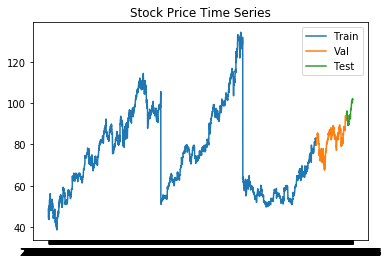

LR Coefficients: 
 [ 2.86319317e-05  2.18683246e-07 -5.60472437e-05  2.99999826e+00
 -1.31575842e-07 -6.66665451e-01 -4.44444934e-01 -2.96293725e-01
 -1.97527829e-01 -1.31684554e-01 -8.77924027e-02 -5.85238113e-02
 -3.90170673e-02 -2.60122156e-02 -1.73384340e-02 -1.15617915e-02
 -7.70529019e-03 -5.13746204e-03 -3.42323408e-03 -2.28258190e-03
 -1.52126003e-03 -1.01400226e-03 -6.76292458e-04 -4.51463158e-04
 -3.00626101e-04 -1.98775877e-04 -1.34033703e-04 -9.04813097e-05
 -5.61140117e-05 -8.89580586e-05  2.41076021e-06  1.09280868e-06
 -1.22082915e-07 -1.70079104e-06 -8.90064043e-07  8.05544038e-08
 -5.15593784e-06  7.68675836e-07 -6.43325289e-08  1.18851371e-05
 -1.47904572e-06  1.04805231e-07 -4.22732476e-06  6.57126298e-07
 -5.07598096e-08  3.71141758e-06  1.06835580e-07 -2.69685226e-08
 -1.27896998e-05 -8.11412685e-07  1.29336363e-07  9.68171634e-06
  4.34759448e-07 -9.08733476e-08 -1.17084635e-05  3.77819492e-07
  8.98493061e-08  7.02220507e-06 -1.75620518e-07 -5.18552718e-08
  3.15

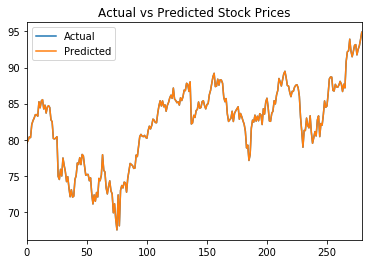

 
Training Random Forest Model
Splitting the data into Train and Test ...
 
Historical Stock Data length is -  2805
Training Set length -  2468
Validation Set length -  280
Test Set length -  56
(2468, 70) (280, 70) (57, 70)
(2468,) (280,) (57,)
Evaluating Metrics - MAE, MAPE, RMSE, R Square
 
Updating the metrics tracker....
 
Predicted vs Actual for  Random Forest
Stock Prediction on Test Data -            Date  Actual  Predicted
0   2018-09-04   79.60    81.0965
1   2018-09-05   79.92    80.2165
2   2018-09-06   80.40    80.6904
3   2018-09-07   80.30    80.5252
4   2018-09-10   82.10    81.4044
..         ...     ...        ...
275 2019-10-08   91.75    92.6065
276 2019-10-09   92.52    92.6243
277 2019-10-10   93.00    92.9973
278 2019-10-11   93.88    93.3617
279 2019-10-14   94.88    94.2836

[280 rows x 3 columns]
Plotting Actual vs Predicted for -  Random Forest


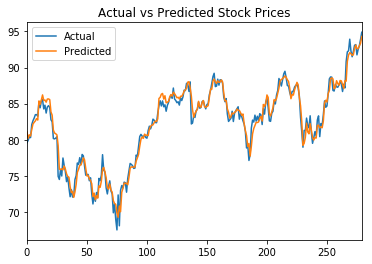

 
Training XGBoost Model
Splitting the data into Train and Test ...
 
Historical Stock Data length is -  2805
Training Set length -  2468
Validation Set length -  280
Test Set length -  56
(2468, 70) (280, 70) (57, 70)
(2468,) (280,) (57,)
Evaluating Metrics - MAE, MAPE, RMSE, R Square
 
Updating the metrics tracker....


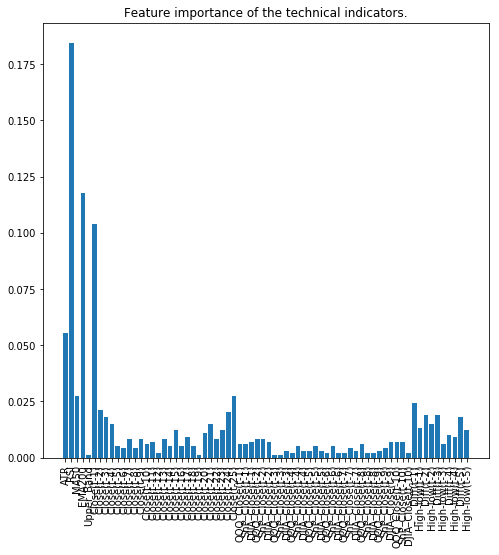

 
Predicted vs Actual for  XGBoost
Stock Prediction on Test Data -            Date  Actual  Predicted
0   2018-09-04   79.60  80.343773
1   2018-09-05   79.92  78.731796
2   2018-09-06   80.40  80.465660
3   2018-09-07   80.30  80.724518
4   2018-09-10   82.10  81.313210
..         ...     ...        ...
275 2019-10-08   91.75  92.779160
276 2019-10-09   92.52  92.670105
277 2019-10-10   93.00  92.982704
278 2019-10-11   93.88  92.550323
279 2019-10-14   94.88  94.357704

[280 rows x 3 columns]
Plotting Actual vs Predicted for -  XGBoost


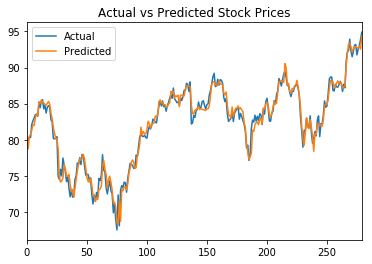

 
Training LSTM Model
Splitting the data into Train and Test ...
 
Scaling feature and target for LSTM....
Historical Stock Data length is -  2805
Training Set length -  2440
Test Set length -  364
(2440, 70) (365, 70)
(2440, 1) (365, 1)
(2440, 70, 1) (2440, 1) (365, 70, 1) (365, 1)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 70, 32)            4352      
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 12,705
Trainable params: 12,705
Non-trainable params: 0
_________________________________________________________________
Train on 2440 samples, validate on 365 samples
Epoch 1/20
2440/2440 [==============================] - 18s 7ms/step - 

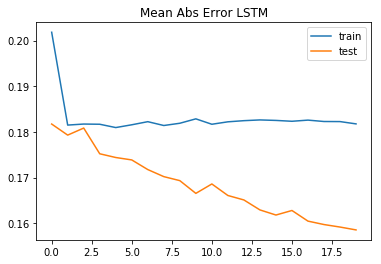

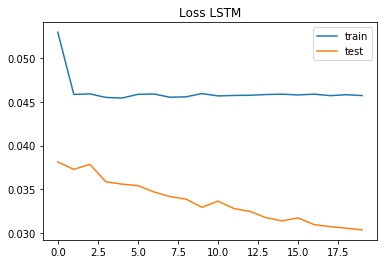

365/365 [==============================] - 0s 1ms/step
Mean Absolute Error for Y: [0.030389483084213242, 0.15855371862241666]
Evaluating Metrics - MAE, MAPE, RMSE, R Square
 
Updating the metrics tracker....


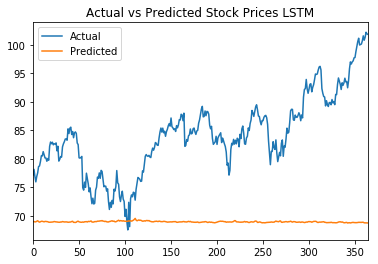

Saving Metrics in Json for Stock -  NKE
z=None
Initiating Pipeline for Stock Ticker ----  IBM
Loading Historical Price data for IBM....
Index(['Close', 'Diff', 'High-low', 'QQQ_Close', 'SnP_Close', 'DJIA_Close',
       'ATR', 'RSI', 'MA50', 'EMA200', 'Upper_Band'],
      dtype='object')
Preparing Lagged Features for Stock, Index Funds.....
Removing NAN rows -  26
Index(['Close', 'ATR', 'RSI', 'MA50', 'EMA200', 'Upper_Band', 'Close(t-1)',
       'Close(t-2)', 'Close(t-3)', 'Close(t-4)', 'Close(t-5)', 'Close(t-6)',
       'Close(t-7)', 'Close(t-8)', 'Close(t-9)', 'Close(t-10)', 'Close(t-11)',
       'Close(t-12)', 'Close(t-13)', 'Close(t-14)', 'Close(t-15)',
       'Close(t-16)', 'Close(t-17)', 'Close(t-18)', 'Close(t-19)',
       'Close(t-20)', 'Close(t-21)', 'Close(t-22)', 'Close(t-23)',
       'Close(t-24)', 'Close(t-25)', 'QQQ_Close(t-1)', 'SnP_Close(t-1)',
       'DJIA_Close(t-1)', 'QQQ_Close(t-2)', 'SnP_Close(t-2)',
       'DJIA_Close(t-2)', 'QQQ_Close(t-3)', 'SnP_Close(t-3)',
    

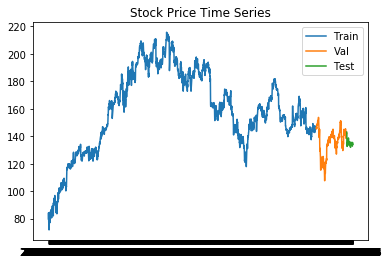

LR Coefficients: 
 [ 9.66587388e-06  1.95659224e-06 -5.47061094e-05  2.99998308e+00
 -5.76785568e-06 -6.66660553e-01 -4.44443217e-01 -2.96292834e-01
 -1.97526364e-01 -1.31683408e-01 -8.77894922e-02 -5.85251136e-02
 -3.90142846e-02 -2.60129249e-02 -1.73390599e-02 -1.15582658e-02
 -7.70465630e-03 -5.13769862e-03 -3.42445576e-03 -2.28050391e-03
 -1.52136179e-03 -1.01557781e-03 -6.76203012e-04 -4.50377400e-04
 -3.00977229e-04 -1.99309145e-04 -1.31030272e-04 -8.75140249e-05
 -5.73376758e-05 -9.02386260e-05 -5.13604472e-06  2.29546177e-07
 -3.10203037e-08  4.44238648e-06  1.63984996e-07 -1.02922795e-08
  5.50988448e-06 -4.24048126e-07  1.73969732e-08  2.85345793e-06
 -4.22260613e-07  4.57982124e-08 -6.40362553e-07 -3.59002531e-07
  6.51672359e-08  3.32006625e-06  3.38404660e-07 -8.35390335e-08
 -3.74598844e-06 -1.88752378e-07  3.89655787e-08  4.83329113e-06
  7.92139019e-07 -1.35078338e-07 -1.62926599e-05  1.41157341e-06
 -4.45959699e-08  4.76118340e-06 -1.48377317e-06  1.32561882e-07
  6.69

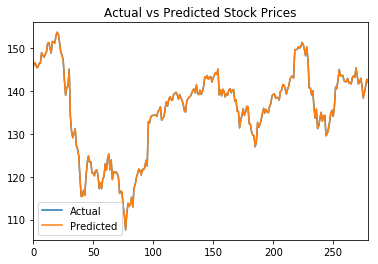

 
Training Random Forest Model
Splitting the data into Train and Test ...
 
Historical Stock Data length is -  2805
Training Set length -  2468
Validation Set length -  280
Test Set length -  56
(2468, 70) (280, 70) (57, 70)
(2468,) (280,) (57,)
Evaluating Metrics - MAE, MAPE, RMSE, R Square
 
Updating the metrics tracker....
 
Predicted vs Actual for  Random Forest
Stock Prediction on Test Data -            Date  Actual  Predicted
0   2018-09-04  145.68   146.4361
1   2018-09-05  146.66   146.5906
2   2018-09-06  146.39   146.4531
3   2018-09-07  145.45   146.2528
4   2018-09-10  145.65   145.6690
..         ...     ...        ...
275 2019-10-08  138.38   140.9346
276 2019-10-09  139.67   139.9836
277 2019-10-10  141.13   140.6821
278 2019-10-11  142.76   142.3534
279 2019-10-14  142.04   142.9185

[280 rows x 3 columns]
Plotting Actual vs Predicted for -  Random Forest


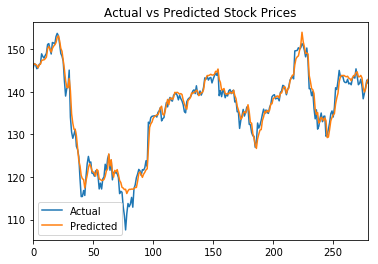

 
Training XGBoost Model
Splitting the data into Train and Test ...
 
Historical Stock Data length is -  2805
Training Set length -  2468
Validation Set length -  280
Test Set length -  56
(2468, 70) (280, 70) (57, 70)
(2468,) (280,) (57,)
Evaluating Metrics - MAE, MAPE, RMSE, R Square
 
Updating the metrics tracker....


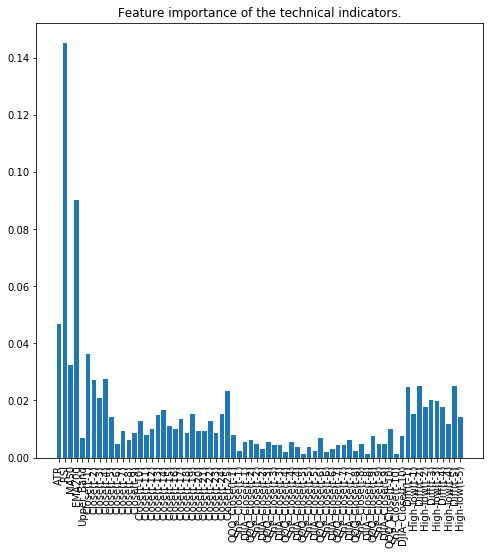

 
Predicted vs Actual for  XGBoost
Stock Prediction on Test Data -            Date  Actual   Predicted
0   2018-09-04  145.68  146.295654
1   2018-09-05  146.66  146.115265
2   2018-09-06  146.39  146.038406
3   2018-09-07  145.45  145.548965
4   2018-09-10  145.65  145.648438
..         ...     ...         ...
275 2019-10-08  138.38  140.345673
276 2019-10-09  139.67  141.079163
277 2019-10-10  141.13  141.993820
278 2019-10-11  142.76  142.927444
279 2019-10-14  142.04  143.011566

[280 rows x 3 columns]
Plotting Actual vs Predicted for -  XGBoost


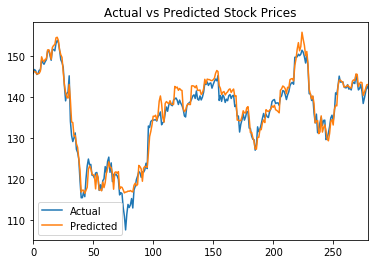

 
Training LSTM Model
Splitting the data into Train and Test ...
 
Scaling feature and target for LSTM....
Historical Stock Data length is -  2805
Training Set length -  2440
Test Set length -  364
(2440, 70) (365, 70)
(2440, 1) (365, 1)
(2440, 70, 1) (2440, 1) (365, 70, 1) (365, 1)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 70, 32)            4352      
_________________________________________________________________
lstm_4 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 12,705
Trainable params: 12,705
Non-trainable params: 0
_________________________________________________________________
Train on 2440 samples, validate on 365 samples
Epoch 1/20
2440/2440 [==============================] - 19s 8ms/step - 

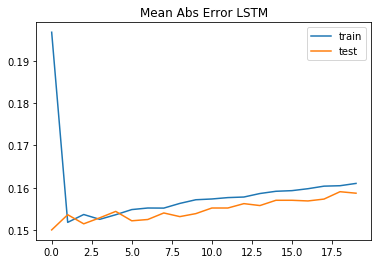

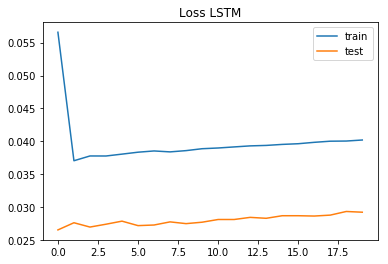

365/365 [==============================] - 0s 1ms/step
Mean Absolute Error for Y: [0.02922598760421962, 0.15873184453134667]
Evaluating Metrics - MAE, MAPE, RMSE, R Square
 
Updating the metrics tracker....


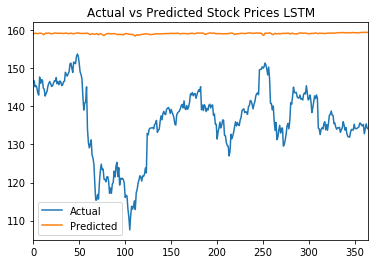

Saving Metrics in Json for Stock -  IBM
z=None
Initiating Pipeline for Stock Ticker ----  KO
Loading Historical Price data for KO....
Index(['Close', 'Diff', 'High-low', 'QQQ_Close', 'SnP_Close', 'DJIA_Close',
       'ATR', 'RSI', 'MA50', 'EMA200', 'Upper_Band'],
      dtype='object')
Preparing Lagged Features for Stock, Index Funds.....
Removing NAN rows -  26
Index(['Close', 'ATR', 'RSI', 'MA50', 'EMA200', 'Upper_Band', 'Close(t-1)',
       'Close(t-2)', 'Close(t-3)', 'Close(t-4)', 'Close(t-5)', 'Close(t-6)',
       'Close(t-7)', 'Close(t-8)', 'Close(t-9)', 'Close(t-10)', 'Close(t-11)',
       'Close(t-12)', 'Close(t-13)', 'Close(t-14)', 'Close(t-15)',
       'Close(t-16)', 'Close(t-17)', 'Close(t-18)', 'Close(t-19)',
       'Close(t-20)', 'Close(t-21)', 'Close(t-22)', 'Close(t-23)',
       'Close(t-24)', 'Close(t-25)', 'QQQ_Close(t-1)', 'SnP_Close(t-1)',
       'DJIA_Close(t-1)', 'QQQ_Close(t-2)', 'SnP_Close(t-2)',
       'DJIA_Close(t-2)', 'QQQ_Close(t-3)', 'SnP_Close(t-3)',
      

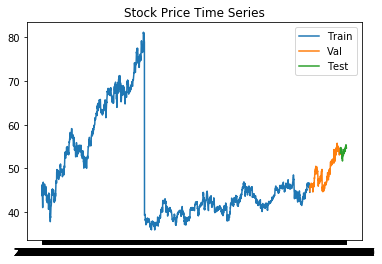

LR Coefficients: 
 [-2.26315628e-06 -4.58608560e-07 -5.56791556e-05  3.00000761e+00
  1.47872147e-06 -6.66666064e-01 -4.44444991e-01 -2.96294941e-01
 -1.97531948e-01 -1.31685154e-01 -8.77924307e-02 -5.85255117e-02
 -3.90185812e-02 -2.60112867e-02 -1.73403106e-02 -1.15600321e-02
 -7.70628106e-03 -5.13862562e-03 -3.42429402e-03 -2.28220323e-03
 -1.52150268e-03 -1.01324936e-03 -6.74097921e-04 -4.51664791e-04
 -3.00667748e-04 -1.97954280e-04 -1.33249925e-04 -8.84471119e-05
 -5.88485326e-05 -9.15907834e-05 -5.93237014e-06  7.23997791e-07
 -3.52012868e-08  8.96371636e-07 -1.96518799e-07  6.69689237e-09
  3.16328903e-06 -4.82729175e-07  1.87466901e-08  2.06221000e-06
 -2.84755798e-07  2.44786785e-08 -1.13395167e-06  2.43946081e-07
 -1.45507604e-08  1.34472860e-06  1.62989098e-07 -1.99152917e-08
  3.75379988e-06 -6.09691500e-07  3.93484373e-08  2.90179457e-07
 -3.67033776e-08 -6.83166684e-09 -4.83085332e-06  4.42179627e-07
 -1.08998673e-08  5.13119390e-07 -2.65520128e-08  4.08843892e-09
 -1.04

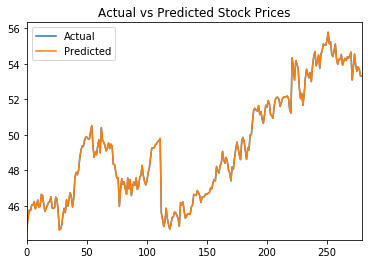

 
Training Random Forest Model
Splitting the data into Train and Test ...
 
Historical Stock Data length is -  2805
Training Set length -  2468
Validation Set length -  280
Test Set length -  56
(2468, 70) (280, 70) (57, 70)
(2468,) (280,) (57,)
Evaluating Metrics - MAE, MAPE, RMSE, R Square
 
Updating the metrics tracker....
 
Predicted vs Actual for  Random Forest
Stock Prediction on Test Data -            Date  Actual  Predicted
0   2018-09-04   44.76    44.5462
1   2018-09-05   45.38    44.9443
2   2018-09-06   45.77    45.5760
3   2018-09-07   45.72    45.7219
4   2018-09-10   46.06    45.8456
..         ...     ...        ...
275 2019-10-08   53.58    53.5956
276 2019-10-09   53.83    53.6404
277 2019-10-10   53.66    53.5708
278 2019-10-11   53.30    53.6039
279 2019-10-14   53.30    53.4637

[280 rows x 3 columns]
Plotting Actual vs Predicted for -  Random Forest


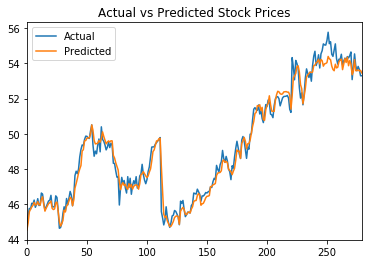

 
Training XGBoost Model
Splitting the data into Train and Test ...
 
Historical Stock Data length is -  2805
Training Set length -  2468
Validation Set length -  280
Test Set length -  56
(2468, 70) (280, 70) (57, 70)
(2468,) (280,) (57,)
Evaluating Metrics - MAE, MAPE, RMSE, R Square
 
Updating the metrics tracker....


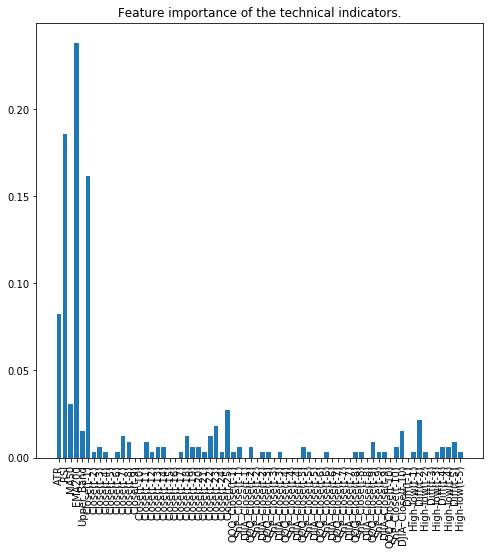

 
Predicted vs Actual for  XGBoost
Stock Prediction on Test Data -            Date  Actual  Predicted
0   2018-09-04   44.76  44.112202
1   2018-09-05   45.38  44.741096
2   2018-09-06   45.77  45.500961
3   2018-09-07   45.72  45.949108
4   2018-09-10   46.06  46.003723
..         ...     ...        ...
275 2019-10-08   53.58  54.326374
276 2019-10-09   53.83  53.313404
277 2019-10-10   53.66  54.296940
278 2019-10-11   53.30  53.141167
279 2019-10-14   53.30  53.226738

[280 rows x 3 columns]
Plotting Actual vs Predicted for -  XGBoost


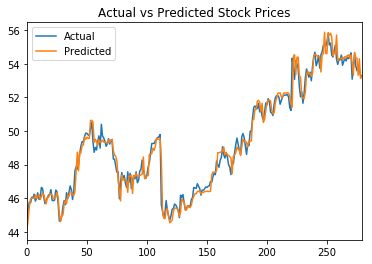

 
Training LSTM Model
Splitting the data into Train and Test ...
 
Scaling feature and target for LSTM....
Historical Stock Data length is -  2805
Training Set length -  2440
Test Set length -  364
(2440, 70) (365, 70)
(2440, 1) (365, 1)
(2440, 70, 1) (2440, 1) (365, 70, 1) (365, 1)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 70, 32)            4352      
_________________________________________________________________
lstm_6 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 12,705
Trainable params: 12,705
Non-trainable params: 0
_________________________________________________________________
Train on 2440 samples, validate on 365 samples
Epoch 1/20
2440/2440 [==============================] - 19s 8ms/step - 

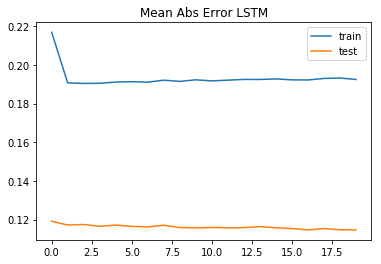

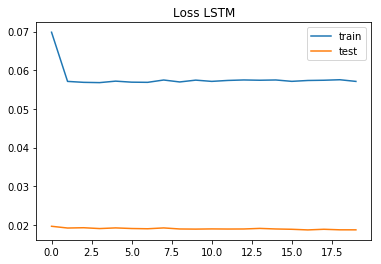

365/365 [==============================] - 0s 1ms/step
Mean Absolute Error for Y: [0.018728456551795954, 0.11467733085155488]
Evaluating Metrics - MAE, MAPE, RMSE, R Square
 
Updating the metrics tracker....


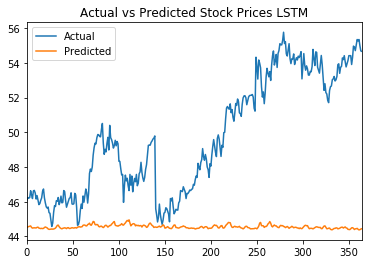

Saving Metrics in Json for Stock -  KO
z=None
Initiating Pipeline for Stock Ticker ----  GS
Loading Historical Price data for GS....
Index(['Close', 'Diff', 'High-low', 'QQQ_Close', 'SnP_Close', 'DJIA_Close',
       'ATR', 'RSI', 'MA50', 'EMA200', 'Upper_Band'],
      dtype='object')
Preparing Lagged Features for Stock, Index Funds.....
Removing NAN rows -  26
Index(['Close', 'ATR', 'RSI', 'MA50', 'EMA200', 'Upper_Band', 'Close(t-1)',
       'Close(t-2)', 'Close(t-3)', 'Close(t-4)', 'Close(t-5)', 'Close(t-6)',
       'Close(t-7)', 'Close(t-8)', 'Close(t-9)', 'Close(t-10)', 'Close(t-11)',
       'Close(t-12)', 'Close(t-13)', 'Close(t-14)', 'Close(t-15)',
       'Close(t-16)', 'Close(t-17)', 'Close(t-18)', 'Close(t-19)',
       'Close(t-20)', 'Close(t-21)', 'Close(t-22)', 'Close(t-23)',
       'Close(t-24)', 'Close(t-25)', 'QQQ_Close(t-1)', 'SnP_Close(t-1)',
       'DJIA_Close(t-1)', 'QQQ_Close(t-2)', 'SnP_Close(t-2)',
       'DJIA_Close(t-2)', 'QQQ_Close(t-3)', 'SnP_Close(t-3)',
       

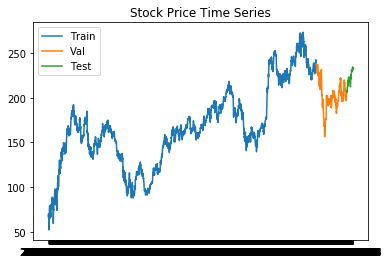

LR Coefficients: 
 [ 9.71316661e-06  1.49421563e-06 -5.56233267e-05  2.99999498e+00
 -7.76487653e-07 -6.66664117e-01 -4.44445010e-01 -2.96291721e-01
 -1.97527710e-01 -1.31684698e-01 -8.77931986e-02 -5.85228454e-02
 -3.90158246e-02 -2.60088241e-02 -1.73457878e-02 -1.15621523e-02
 -7.70739691e-03 -5.13645695e-03 -3.42465643e-03 -2.28142612e-03
 -1.52112544e-03 -1.01443681e-03 -6.73751288e-04 -4.49948138e-04
 -3.01249634e-04 -1.98949955e-04 -1.33093306e-04 -8.84899322e-05
 -5.98308823e-05 -8.65361378e-05  4.81545502e-06  7.14254201e-07
 -9.14832661e-08 -2.35689591e-06 -4.98567477e-07  9.95474536e-08
  1.41621997e-05 -3.59391636e-06  2.81999415e-07  8.43714071e-06
 -3.65167257e-07 -3.11832347e-08 -6.30391219e-06  1.69736492e-06
 -1.65412425e-07  8.81079113e-06 -1.65827272e-06  1.56683288e-07
 -5.11104614e-06  8.71628824e-07 -1.32938574e-07  5.16626308e-06
 -1.07877408e-07 -4.06674666e-08 -9.99321081e-06  3.35875695e-07
  9.34641464e-09 -1.54893895e-05  2.50991367e-06 -8.85516824e-08
 -1.11

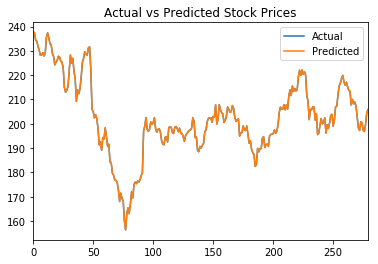

 
Training Random Forest Model
Splitting the data into Train and Test ...
 
Historical Stock Data length is -  2805
Training Set length -  2468
Validation Set length -  280
Test Set length -  56
(2468, 70) (280, 70) (57, 70)
(2468,) (280,) (57,)
Evaluating Metrics - MAE, MAPE, RMSE, R Square
 
Updating the metrics tracker....
 
Predicted vs Actual for  Random Forest
Stock Prediction on Test Data -            Date  Actual  Predicted
0   2018-09-04  237.66   238.3284
1   2018-09-05  237.56   238.0396
2   2018-09-06  234.52   236.7895
3   2018-09-07  233.91   233.5256
4   2018-09-10  231.91   232.3387
..         ...     ...        ...
275 2019-10-08  197.37   201.6727
276 2019-10-09  196.85   199.4907
277 2019-10-10  199.87   199.2573
278 2019-10-11  204.68   199.9796
279 2019-10-14  205.82   206.3989

[280 rows x 3 columns]
Plotting Actual vs Predicted for -  Random Forest


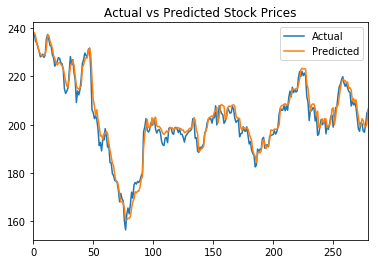

 
Training XGBoost Model
Splitting the data into Train and Test ...
 
Historical Stock Data length is -  2805
Training Set length -  2468
Validation Set length -  280
Test Set length -  56
(2468, 70) (280, 70) (57, 70)
(2468,) (280,) (57,)
Evaluating Metrics - MAE, MAPE, RMSE, R Square
 
Updating the metrics tracker....


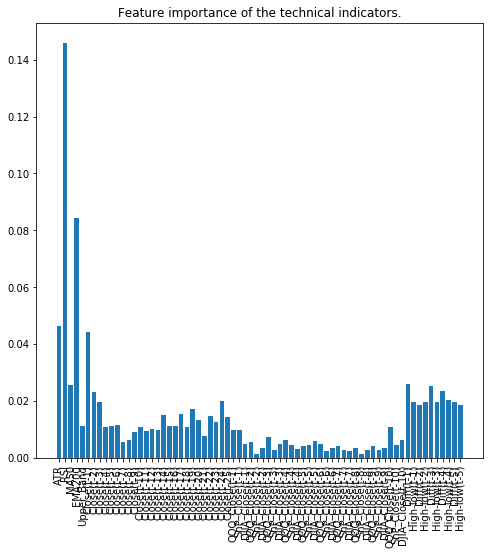

 
Predicted vs Actual for  XGBoost
Stock Prediction on Test Data -            Date  Actual   Predicted
0   2018-09-04  237.66  235.993530
1   2018-09-05  237.56  235.808334
2   2018-09-06  234.52  235.549179
3   2018-09-07  233.91  232.556305
4   2018-09-10  231.91  230.874664
..         ...     ...         ...
275 2019-10-08  197.37  200.865799
276 2019-10-09  196.85  196.955032
277 2019-10-10  199.87  196.782486
278 2019-10-11  204.68  199.894241
279 2019-10-14  205.82  205.824051

[280 rows x 3 columns]
Plotting Actual vs Predicted for -  XGBoost


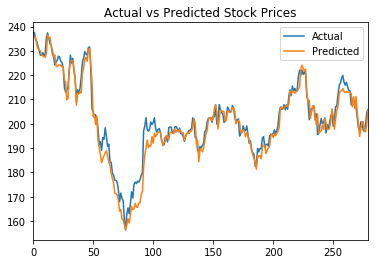

 
Training LSTM Model
Splitting the data into Train and Test ...
 
Scaling feature and target for LSTM....
Historical Stock Data length is -  2805
Training Set length -  2440
Test Set length -  364
(2440, 70) (365, 70)
(2440, 1) (365, 1)
(2440, 70, 1) (2440, 1) (365, 70, 1) (365, 1)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 70, 32)            4352      
_________________________________________________________________
lstm_8 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 12,705
Trainable params: 12,705
Non-trainable params: 0
_________________________________________________________________
Train on 2440 samples, validate on 365 samples
Epoch 1/20
2440/2440 [==============================] - 21s 8ms/step - 

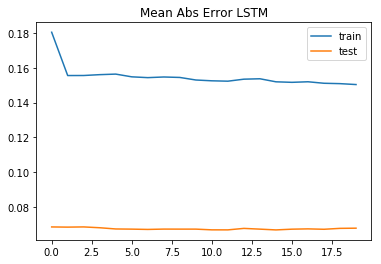

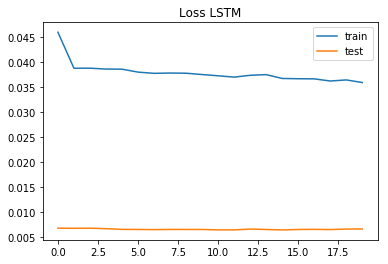

365/365 [==============================] - 1s 2ms/step
Mean Absolute Error for Y: [0.006595501146751315, 0.06766607281688142]
Evaluating Metrics - MAE, MAPE, RMSE, R Square
 
Updating the metrics tracker....


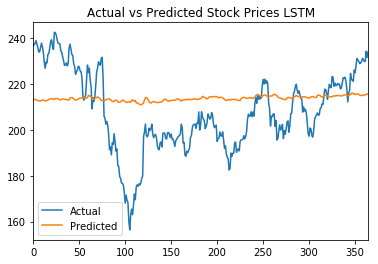

Saving Metrics in Json for Stock -  GS
z=None
Initiating Pipeline for Stock Ticker ----  JNJ
Loading Historical Price data for JNJ....
Index(['Close', 'Diff', 'High-low', 'QQQ_Close', 'SnP_Close', 'DJIA_Close',
       'ATR', 'RSI', 'MA50', 'EMA200', 'Upper_Band'],
      dtype='object')
Preparing Lagged Features for Stock, Index Funds.....
Removing NAN rows -  26
Index(['Close', 'ATR', 'RSI', 'MA50', 'EMA200', 'Upper_Band', 'Close(t-1)',
       'Close(t-2)', 'Close(t-3)', 'Close(t-4)', 'Close(t-5)', 'Close(t-6)',
       'Close(t-7)', 'Close(t-8)', 'Close(t-9)', 'Close(t-10)', 'Close(t-11)',
       'Close(t-12)', 'Close(t-13)', 'Close(t-14)', 'Close(t-15)',
       'Close(t-16)', 'Close(t-17)', 'Close(t-18)', 'Close(t-19)',
       'Close(t-20)', 'Close(t-21)', 'Close(t-22)', 'Close(t-23)',
       'Close(t-24)', 'Close(t-25)', 'QQQ_Close(t-1)', 'SnP_Close(t-1)',
       'DJIA_Close(t-1)', 'QQQ_Close(t-2)', 'SnP_Close(t-2)',
       'DJIA_Close(t-2)', 'QQQ_Close(t-3)', 'SnP_Close(t-3)',
     

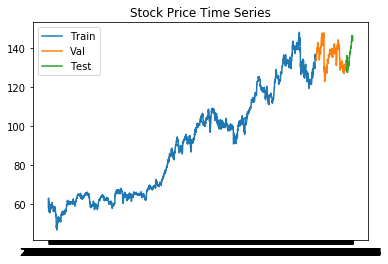

LR Coefficients: 
 [ 2.44525349e-05  1.13510577e-06 -5.61221801e-05  2.99998409e+00
  7.46734028e-08 -6.66660525e-01 -4.44441848e-01 -2.96294464e-01
 -1.97527624e-01 -1.31687854e-01 -8.77831366e-02 -5.85264401e-02
 -3.90144667e-02 -2.60113549e-02 -1.73444631e-02 -1.15603587e-02
 -7.70670247e-03 -5.13338246e-03 -3.42639051e-03 -2.28187117e-03
 -1.52167336e-03 -1.01206302e-03 -6.77373420e-04 -4.48773920e-04
 -2.97485534e-04 -2.00099739e-04 -1.28581436e-04 -9.33861190e-05
 -6.06819381e-05 -8.78423348e-05  2.48851080e-06  5.04064273e-08
 -2.16899501e-08  7.72093826e-07  3.11009571e-07 -5.75754454e-08
  8.00352581e-07 -4.42532460e-07  5.31497607e-08  8.89760152e-07
 -2.04811096e-08  6.55548393e-10 -3.48188793e-06  4.96370547e-07
 -1.74452813e-08  2.07765837e-06  6.51373154e-08 -4.16557091e-08
 -1.65244955e-06 -2.36485908e-07  2.99710246e-08 -1.10230422e-06
  1.28378336e-07 -2.97149039e-08 -3.74660398e-06 -2.97489684e-08
  3.78405958e-08  3.71583828e-06 -2.98161855e-07  4.06482412e-08
 -2.95

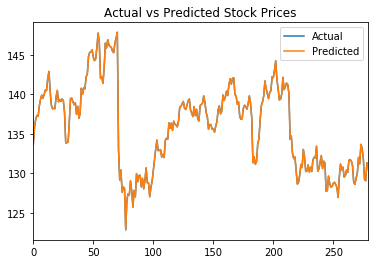

 
Training Random Forest Model
Splitting the data into Train and Test ...
 
Historical Stock Data length is -  2805
Training Set length -  2468
Validation Set length -  280
Test Set length -  56
(2468, 70) (280, 70) (57, 70)
(2468,) (280,) (57,)
Evaluating Metrics - MAE, MAPE, RMSE, R Square
 
Updating the metrics tracker....
 
Predicted vs Actual for  Random Forest
Stock Prediction on Test Data -            Date  Actual  Predicted
0   2018-09-04  133.72   133.7136
1   2018-09-05  135.86   134.2398
2   2018-09-06  136.87   135.9255
3   2018-09-07  137.32   135.8680
4   2018-09-10  137.21   135.8475
..         ...     ...        ...
275 2019-10-08  131.84   132.4277
276 2019-10-09  129.22   131.0300
277 2019-10-10  129.06   129.3153
278 2019-10-11  131.33   130.2998
279 2019-10-14  130.72   130.7240

[280 rows x 3 columns]
Plotting Actual vs Predicted for -  Random Forest


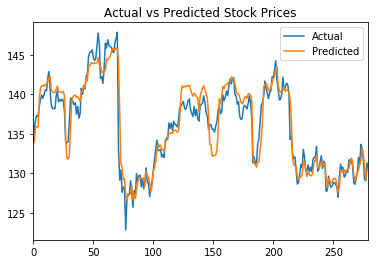

 
Training XGBoost Model
Splitting the data into Train and Test ...
 
Historical Stock Data length is -  2805
Training Set length -  2468
Validation Set length -  280
Test Set length -  56
(2468, 70) (280, 70) (57, 70)
(2468,) (280,) (57,)
Evaluating Metrics - MAE, MAPE, RMSE, R Square
 
Updating the metrics tracker....


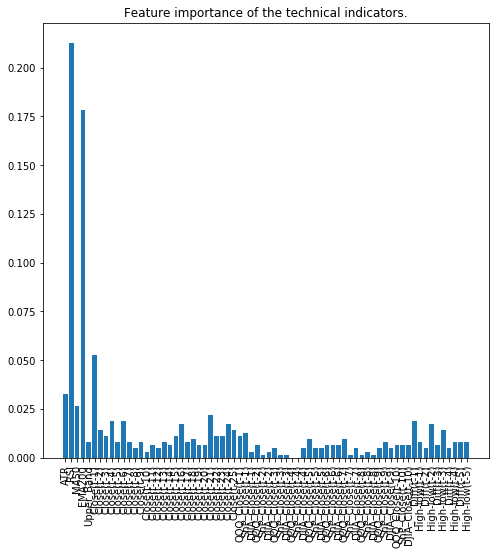

 
Predicted vs Actual for  XGBoost
Stock Prediction on Test Data -            Date  Actual   Predicted
0   2018-09-04  133.72  134.793411
1   2018-09-05  135.86  133.260895
2   2018-09-06  136.87  135.613525
3   2018-09-07  137.32  135.708267
4   2018-09-10  137.21  135.838867
..         ...     ...         ...
275 2019-10-08  131.84  131.242279
276 2019-10-09  129.22  130.432755
277 2019-10-10  129.06  128.366882
278 2019-10-11  131.33  130.226990
279 2019-10-14  130.72  130.436035

[280 rows x 3 columns]
Plotting Actual vs Predicted for -  XGBoost


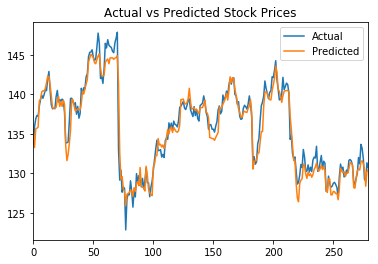

 
Training LSTM Model
Splitting the data into Train and Test ...
 
Scaling feature and target for LSTM....
Historical Stock Data length is -  2805
Training Set length -  2440
Test Set length -  364
(2440, 70) (365, 70)
(2440, 1) (365, 1)
(2440, 70, 1) (2440, 1) (365, 70, 1) (365, 1)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 70, 32)            4352      
_________________________________________________________________
lstm_10 (LSTM)               (None, 32)                8320      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 12,705
Trainable params: 12,705
Non-trainable params: 0
_________________________________________________________________
Train on 2440 samples, validate on 365 samples
Epoch 1/20
2440/2440 [==============================] - 23s 10ms/step -

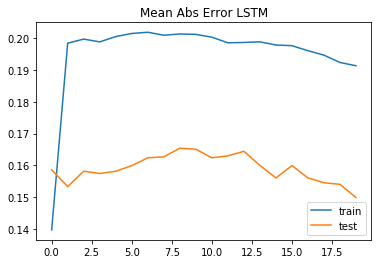

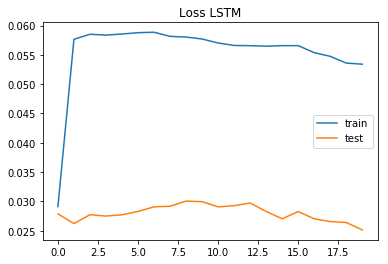

365/365 [==============================] - 0s 1ms/step
Mean Absolute Error for Y: [0.02512862010769648, 0.14987705623450345]
Evaluating Metrics - MAE, MAPE, RMSE, R Square
 
Updating the metrics tracker....


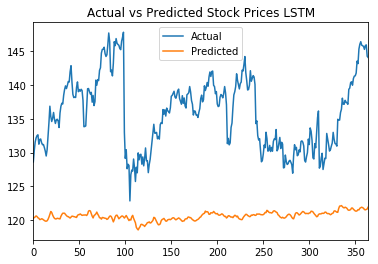

Saving Metrics in Json for Stock -  JNJ
z=None
Initiating Pipeline for Stock Ticker ----  NVDA
Loading Historical Price data for NVDA....
Index(['Close', 'Diff', 'High-low', 'QQQ_Close', 'SnP_Close', 'DJIA_Close',
       'ATR', 'RSI', 'MA50', 'EMA200', 'Upper_Band'],
      dtype='object')
Preparing Lagged Features for Stock, Index Funds.....
Removing NAN rows -  26
Index(['Close', 'ATR', 'RSI', 'MA50', 'EMA200', 'Upper_Band', 'Close(t-1)',
       'Close(t-2)', 'Close(t-3)', 'Close(t-4)', 'Close(t-5)', 'Close(t-6)',
       'Close(t-7)', 'Close(t-8)', 'Close(t-9)', 'Close(t-10)', 'Close(t-11)',
       'Close(t-12)', 'Close(t-13)', 'Close(t-14)', 'Close(t-15)',
       'Close(t-16)', 'Close(t-17)', 'Close(t-18)', 'Close(t-19)',
       'Close(t-20)', 'Close(t-21)', 'Close(t-22)', 'Close(t-23)',
       'Close(t-24)', 'Close(t-25)', 'QQQ_Close(t-1)', 'SnP_Close(t-1)',
       'DJIA_Close(t-1)', 'QQQ_Close(t-2)', 'SnP_Close(t-2)',
       'DJIA_Close(t-2)', 'QQQ_Close(t-3)', 'SnP_Close(t-3)',
  

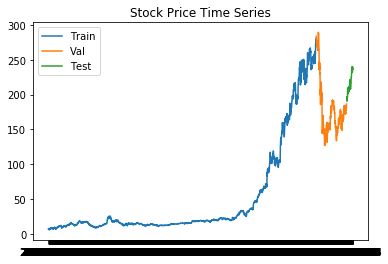

LR Coefficients: 
 [-5.60154153e-05  5.43263609e-08 -5.97003906e-05  3.00000510e+00
  5.21500306e-06 -6.66668342e-01 -4.44442226e-01 -2.96301037e-01
 -1.97533823e-01 -1.31685302e-01 -8.77800644e-02 -5.85256879e-02
 -3.90167701e-02 -2.60126631e-02 -1.73453379e-02 -1.15592457e-02
 -7.70724300e-03 -5.13761204e-03 -3.42491748e-03 -2.28320561e-03
 -1.52527056e-03 -1.01819478e-03 -6.69148958e-04 -4.49322757e-04
 -3.00690191e-04 -1.96521403e-04 -1.25302971e-04 -8.72490777e-05
 -6.69607510e-05 -8.82580789e-05 -3.27160629e-06 -1.94924165e-06
  2.33567802e-07 -1.86398717e-06  3.82655569e-07 -3.99055247e-08
  8.36200219e-09  1.23448199e-06 -1.64117491e-07 -6.92195153e-06
  3.13984964e-07  2.49419815e-08  2.19956997e-06  9.61490110e-07
 -1.33204531e-07  2.27912301e-05 -2.48789676e-06  1.58186673e-07
 -1.99439326e-06 -5.67735726e-07  8.96919194e-08 -3.26364839e-06
  4.55652993e-08  2.03063820e-08 -1.98050519e-06  1.58816545e-06
 -1.56618354e-07 -4.37027172e-06  2.06830258e-07 -1.03386019e-08
  5.54

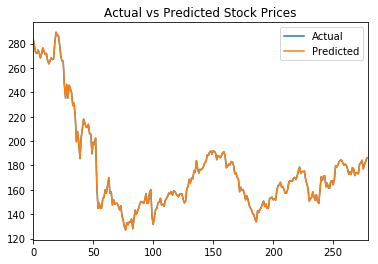

 
Training Random Forest Model
Splitting the data into Train and Test ...
 
Historical Stock Data length is -  2805
Training Set length -  2468
Validation Set length -  280
Test Set length -  56
(2468, 70) (280, 70) (57, 70)
(2468,) (280,) (57,)
Evaluating Metrics - MAE, MAPE, RMSE, R Square
 
Updating the metrics tracker....
 
Predicted vs Actual for  Random Forest
Stock Prediction on Test Data -            Date  Actual  Predicted
0   2018-09-04  283.70   277.6308
1   2018-09-05  278.42   277.0794
2   2018-09-06  272.72   276.3574
3   2018-09-07  271.86   274.9463
4   2018-09-10  274.73   275.3162
..         ...     ...        ...
275 2019-10-08  177.23   188.5210
276 2019-10-09  180.71   187.5392
277 2019-10-10  183.03   188.7925
278 2019-10-11  185.99   189.4727
279 2019-10-14  186.53   189.2600

[280 rows x 3 columns]
Plotting Actual vs Predicted for -  Random Forest


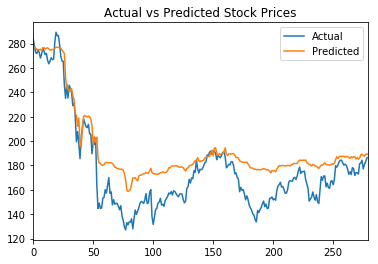

 
Training XGBoost Model
Splitting the data into Train and Test ...
 
Historical Stock Data length is -  2805
Training Set length -  2468
Validation Set length -  280
Test Set length -  56
(2468, 70) (280, 70) (57, 70)
(2468,) (280,) (57,)
Evaluating Metrics - MAE, MAPE, RMSE, R Square
 
Updating the metrics tracker....


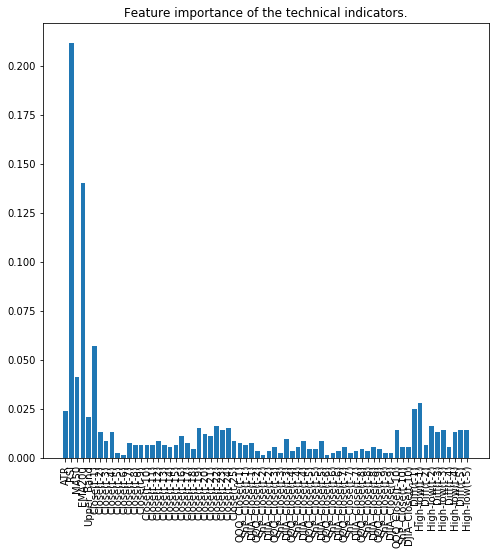

 
Predicted vs Actual for  XGBoost
Stock Prediction on Test Data -            Date  Actual   Predicted
0   2018-09-04  283.70  278.756439
1   2018-09-05  278.42  276.649048
2   2018-09-06  272.72  274.277039
3   2018-09-07  271.86  273.392395
4   2018-09-10  274.73  274.076630
..         ...     ...         ...
275 2019-10-08  177.23  190.716599
276 2019-10-09  180.71  186.750626
277 2019-10-10  183.03  190.543762
278 2019-10-11  185.99  191.047562
279 2019-10-14  186.53  191.044510

[280 rows x 3 columns]
Plotting Actual vs Predicted for -  XGBoost


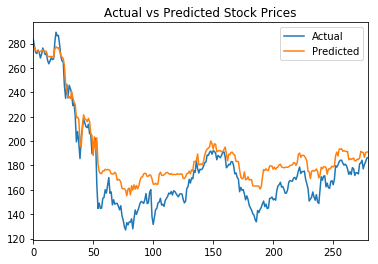

 
Training LSTM Model
Splitting the data into Train and Test ...
 
Scaling feature and target for LSTM....
Historical Stock Data length is -  2805
Training Set length -  2440
Test Set length -  364
(2440, 70) (365, 70)
(2440, 1) (365, 1)
(2440, 70, 1) (2440, 1) (365, 70, 1) (365, 1)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_11 (LSTM)               (None, 70, 32)            4352      
_________________________________________________________________
lstm_12 (LSTM)               (None, 32)                8320      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 33        
Total params: 12,705
Trainable params: 12,705
Non-trainable params: 0
_________________________________________________________________
Train on 2440 samples, validate on 365 samples
Epoch 1/20
2440/2440 [==============================] - 21s 8ms/step - 

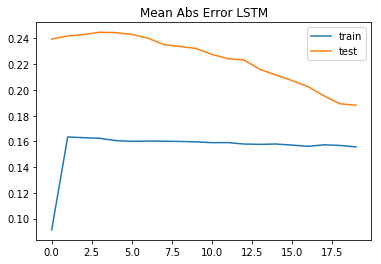

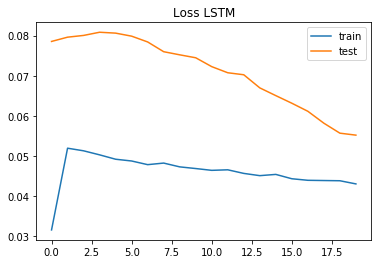

365/365 [==============================] - 0s 1ms/step
Mean Absolute Error for Y: [0.055179546309048186, 0.18811615501364617]
Evaluating Metrics - MAE, MAPE, RMSE, R Square
 
Updating the metrics tracker....


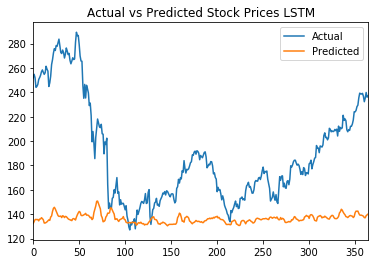

Saving Metrics in Json for Stock -  NVDA
z=None


In [3]:
Stocks = ['NKE', 'IBM', 'KO', 'GS', 'JNJ', 'NVDA']
models = ['Linear Regression', 'Random Forest', 'XGBoost', 'LSTM']
training = Stock_Prediction_Modeling(Stocks, models)
training.pipeline_sequence()

In [4]:
import json

with open('metrics.txt') as f:
    eval_metrics = json.load(f)
    
eval_metrics

{'NKE': {'Linear Regression': {'Train_MAE': 0.0,
   'Train_RSq': 1.0,
   'Train_MAPE': 0.0,
   'Train_RMSE': 0.0,
   'Test_MAE': 0.0,
   'Test_RSq': 1.0,
   'Test_MAPE': 0.0,
   'Test_RMSE': 0.0},
  'Random Forest': {'Train_MAE': 0.22,
   'Train_RSq': 1.0,
   'Train_MAPE': 0.3,
   'Train_RMSE': 0.57,
   'Test_MAE': 0.68,
   'Test_RSq': 0.97,
   'Test_MAPE': 0.85,
   'Test_RMSE': 0.93},
  'XGBoost': {'Train_MAE': 0.29,
   'Train_RSq': 1.0,
   'Train_MAPE': 0.4,
   'Train_RMSE': 0.36,
   'Test_MAE': 0.67,
   'Test_RSq': 0.97,
   'Test_MAPE': 0.84,
   'Test_RMSE': 0.93},
  'LSTM': {'Train_MAE': 16.56,
   'Train_RSq': -0.08,
   'Train_MAPE': 21.4,
   'Train_RMSE': 20.75,
   'Test_MAE': 15.18,
   'Test_RSq': -4.85,
   'Test_MAPE': 17.5,
   'Test_RMSE': 16.69}},
 'IBM': {'Linear Regression': {'Train_MAE': 0.0,
   'Train_RSq': 1.0,
   'Train_MAPE': 0.0,
   'Train_RMSE': 0.0,
   'Test_MAE': 0.0,
   'Test_RSq': 1.0,
   'Test_MAPE': 0.0,
   'Test_RMSE': 0.0},
  'Random Forest': {'Train_MAE': 0.3

In [5]:
Metrics = pd.DataFrame.from_dict({(i,j): eval_metrics[i][j] 
                           for i in eval_metrics.keys() 
                           for j in eval_metrics[i].keys()},
                       orient='index')
Metrics

Train_MAE  Train_RSq  Train_MAPE  Train_RMSE  \
NKE  Linear Regression       0.00       1.00        0.00        0.00   
     Random Forest           0.22       1.00        0.30        0.57   
     XGBoost                 0.29       1.00        0.40        0.36   
     LSTM                   16.56      -0.08       21.40       20.75   
IBM  Linear Regression       0.00       1.00        0.00        0.00   
     Random Forest           0.32       1.00        0.21        0.48   
     XGBoost                 0.31       1.00        0.20        0.40   
     LSTM                   24.06       0.00       16.77       29.73   
KO   Linear Regression       0.00       1.00        0.00        0.00   
     Random Forest           0.09       1.00        0.19        0.30   
     XGBoost                 0.21       1.00        0.45        0.28   
     LSTM                    7.75      -0.11       13.87       11.38   
GS   Linear Regression       0.00       1.00        0.00        0.00   
     Random Forest           0.49       1.00        0.32        0.69   
     XGBoost                 0.32       1.00        0.21        0.41   
     LSTM                   46.42      -0.54       35.62       54.62   
JNJ  Linear Regression       0.00       1.00        0.00        0.00   
     Random Forest           0.15       1.00        0.17        0.24   
     XGBoost                 0.26       1.00        0.31        0.34   
     LSTM                   29.13      -0.72       42.05       34.40   
NVDA Linear Regression       0.00       1.00        0.00        0.00   
     Random Forest           0.25       1.00        0.48        0.61   
     XGBoost                 0.20       1.00        0.88        0.28   
     LSTM                   78.87      -0.59      449.12       81.48   

                        Test_MAE  Test_RSq  Test_MAPE  Test_RMSE  
NKE  Linear Regression      0.00      1.00       0.00       0.00  
     Random Forest          0.68      0.97       0.85       0.93  
     XGBoost                0.67      0.97       0.84       0.93  
     LSTM                  15.18     -4.85      17.50      16.69  
IBM  Linear Regression      0.00      1.00       0.00       0.00  
     Random Forest          1.22      0.97       0.94       1.75  
     XGBoost                1.44      0.96       1.09       1.90  
     LSTM                  22.87     -6.14      17.35      24.63  
KO   Linear Regression      0.00      1.00       0.00       0.00  
     Random Forest          0.33      0.98       0.66       0.46  
     XGBoost                0.36      0.97       0.72       0.50  
     LSTM                   5.18     -2.38      10.00       6.18  
GS   Linear Regression      0.00      1.00       0.00       0.00  
     Random Forest          2.33      0.96       1.17       3.08  
     XGBoost                2.80      0.94       1.42       3.86  
     LSTM                  14.98     -0.06       7.49      17.98  
JNJ  Linear Regression      0.00      1.00       0.00       0.00  
     Random Forest          1.24      0.90       0.91       1.71  
     XGBoost                0.93      0.94       0.69       1.27  
     LSTM                  15.22     -8.05      11.07      16.10  
NVDA Linear Regression      0.00      1.00       0.00       0.00  
     Random Forest         16.75      0.72      10.68      20.00  
     XGBoost               14.05      0.81       8.89      16.33  
     LSTM                  53.32     -1.58      25.14      66.59

In [6]:
Metrics.to_csv('Evaluation.csv')

### Conclusion

Random Forest, XG Boost and Linear regression seems to work very well on such a long data as well. We have taken around 12-15 years of historical data which was divided into Training, Validation and Testing. 

These algorithms are able to catch the trend and move close to the Actual closing price in the right direction with a very low Mean Absolute error(MAE). The Evaluation Metrics is above to see how each algorithm performed on each stock. They worked so well because of the Feature Extraction we did to extract around 60 features including lagged Index funds prices, Technical Indicators like Exponential Moving Average, RSI, ADR, Willam's R, bollinger bands and many more. 

LSTMs did not perform well on this as expected, as the data is not using any sequence of previous many time steps. and LSTM will work better on time series data once we provide it with previous 30-60 days of lookback data for every prediction. 
Thats what we will be doing in the next Notebooks and then we will move to Portfolio Optimization. 

### License
MIT License

Copyright (c) 2020 Nikhil Kohli

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.